## Classifying Juvenile Idiopathic Arthritis (JIA)

Special thanks to Sevda Gharehbaghi and Kristy Scott Richardson for their help in putting together this code. 

JIA classification is an ongoing project in the <a href="http://www.irl.gatech.edu" target="_blank">Inan Research Lab</a>. 

Background on JIA, the protocol to collect the data, preprocessing information, and feature extraction details are shared in the following paper: 

<a href="https://www.frontiersin.org/articles/10.3389/fdgth.2020.571839/full" target="_blank">Knee Acoustic Emissions as a Digital Biomarker of Disease Status in Juvenile Idiopathic Arthritis</a> 


To summarize the dataset, 20 subjects with JIA and 18 healthy subjects had 4 miniature microphones attached to their knees during a short flexion extension exercise. Each subject repeated this exercise multiple times. Although choosing features and extracting them consistently across subjects is a very important part of the process, for the purposes of this notebook we will skip to importing the extracted feature set for analysis. 

***

#### First step: import the important

In [1]:
import numpy as np       
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat 
import sklearn
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix

#### Let's load the dataset and see what it looks like: (abbreviated)

#### Note: if you are using Google Colab to run this notebook, you will need to upload 'JIA_data.csv' to your google drive and then mount your drive so you can access the data in Colab (and change the file path as necessary in the read_csv function). Please go through this tutorial to do learn how to do this: <a href="https://medium.com/@steve7an/how-to-test-jupyter-notebook-from-github-via-google-colab-7dc4b9b11a19" target="_blank">Google Colab/Github tutorial</a> 



In [2]:
JIA_dataset = pd.read_csv('JIA_data.csv')

data_top = JIA_dataset.head(); 
print(data_top)

            Row  No  Subject  Label  Mic  Cycle No  Cycle Index_1  \
0  s2001_R1_Cy1   1     2001      1    1         1   2.878006e+05   
1  s2001_R1_Cy2   2     2001      1    1         2   6.129482e+05   
2  s2001_R1_Cy3   3     2001      1    1         3   1.061125e+06   
3  s2001_R1_Cy4   4     2001      1    1         4   1.381878e+06   
4  s2001_R1_Cy5   5     2001      1    1         5   1.821267e+06   

   Cycle Index_2  NoiseLevel   ZCRMean  ...  BandPower28Std  BandPower29Std  \
0   6.129482e+05         0.0  0.193399  ...        0.025303        0.030703   
1   1.061125e+06         0.0  0.192975  ...        0.022297        0.026709   
2   1.381878e+06         0.0  0.194588  ...        0.022515        0.025160   
3   1.821267e+06         0.0  0.195833  ...        0.022675        0.023708   
4   2.163990e+06         0.0  0.198495  ...        0.024454        0.025420   

   RMSAmplitudeStd  MeanFreqStd  SpectralCrestStd  SpectralDecreaseStd  \
0     2.281846e-07  1954.379670     

***

#### It looks like we have 225 columns in this dataset. Let's print those out so we can see what we are working with. 

#### The full list of feature names is below. For more information on what these features are and how they were extracted, please look at the paper linked above and especially the supplementary table in the paper. 

In [3]:
list(JIA_dataset.columns)

['Row',
 'No',
 'Subject',
 'Label',
 'Mic',
 'Cycle No',
 'Cycle Index_1',
 'Cycle Index_2',
 'NoiseLevel',
 'ZCRMean',
 'EnergyMean',
 'EnergyEntropyMean',
 'SpectralCentroidMean',
 'SpectralSpreadMean',
 'SpectralEntropyMean',
 'SpectralFluxMean',
 'SpectralRolloffMean',
 'MFCC1Mean',
 'MFCC2Mean',
 'MFCC3Mean',
 'MFCC4Mean',
 'MFCC5Mean',
 'MFCC6Mean',
 'MFCC7Mean',
 'MFCC8Mean',
 'MFCC9Mean',
 'MFCC10Mean',
 'MFCC11Mean',
 'MFCC12Mean',
 'MFCC13Mean',
 'HRMean',
 'F0Mean',
 'Chroma1Mean',
 'Chroma2Mean',
 'Chroma3Mean',
 'Chroma4Mean',
 'Chroma5Mean',
 'Chroma6Mean',
 'Chroma7Mean',
 'Chroma8Mean',
 'Chroma9Mean',
 'Chroma10Mean',
 'Chroma11Mean',
 'Chroma12Mean',
 'BandPower1Mean',
 'BandPower2Mean',
 'BandPower3Mean',
 'BandPower4Mean',
 'BandPower5Mean',
 'BandPower6Mean',
 'BandPower7Mean',
 'BandPower8Mean',
 'BandPower9Mean',
 'BandPower10Mean',
 'BandPower11Mean',
 'BandPower12Mean',
 'BandPower13Mean',
 'BandPower14Mean',
 'BandPower15Mean',
 'BandPower16Mean',
 'BandPower

#### As you scroll through these, you should see some repetition. After the first few columns, we have the mean, median and standard deviation of a set of 72 features. 

#### The first 9 columns aren't features. One of these values is the label! Here 0 means healthy, 1 means JIA. 

#### We'll have to remove these columns to create the actual feature matrix X and label vector y. But there may be some information in those other columns worth looking at, such as the mic number, cycle number or noise level. 

#### After we remove the columns, we'll print the abbreviated dataset again to make sure they are gone. 

#### We also pull the subject number for later use. In biomedical machine learning applications, you always need the subject number if you have more than one example per subject. DO NOT EVER FORGET THIS. EVER. 

In [4]:
data_copy = JIA_dataset.copy() 
cut_columns = ['Row','No','Subject','Label','Mic','Cycle No','Cycle Index_1','Cycle Index_2','NoiseLevel']
X = data_copy.drop(cut_columns,axis=1)

# let's make sure that those columns are gone 
X_top = X.head(); 
print(X_top)
    
y = JIA_dataset['Label'] # here 0 means healthy, 1 means JIA 
subject = JIA_dataset['Subject'] # DO NOT EVER FORGET THIS. EVER

    ZCRMean    EnergyMean  EnergyEntropyMean  SpectralCentroidMean  \
0  0.193399  1.429015e-12           2.657369              0.182399   
1  0.192975  1.373220e-12           2.665292              0.181554   
2  0.194588  1.448181e-12           2.638746              0.181995   
3  0.195833  1.344418e-12           2.651122              0.182287   
4  0.198495  1.357054e-12           2.644915              0.183478   

   SpectralSpreadMean  SpectralEntropyMean  SpectralFluxMean  \
0            0.118783             1.819356          0.000160   
1            0.118481             1.831729          0.000160   
2            0.118616             1.830934          0.000182   
3            0.118440             1.849215          0.000152   
4            0.117750             1.856121          0.000170   

   SpectralRolloffMean  MFCC1Mean  MFCC2Mean  ...  BandPower28Std  \
0             0.331406 -55.884273   0.364607  ...        0.025303   
1             0.333207 -55.761175   0.554025  ...       

#### Now let's take a peek at some of these features. 

#### Below we plot the kernel density estimation plot for one of the features. 

#### Replace 'variable_to_plot' with other column names to explore what other features look like. 

#### Remember that 'good' features will have separation left to right in the kde plot, and it doesn't always have to be linear separation (depending on your classifier choice). 

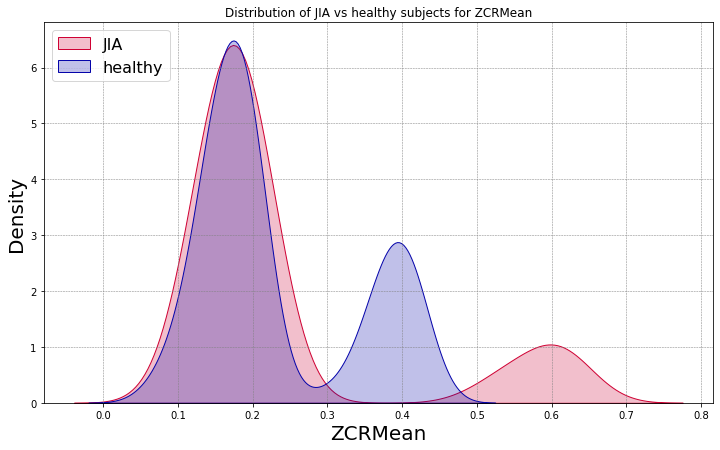

In [5]:
# plot a feature on a kde plot

JIA = X[y==1]
healthy = X[y==0]

variable_to_plot = 'ZCRMean' # choose different column names and see what the distributions look like! 

fig = plt.figure(figsize=(12,7)); # initialize your plot
ax1 = sns.kdeplot(JIA[variable_to_plot]  ,
    shade=True, color="xkcd:cherry" , label="JIA") # distribution of JIA subjects
ax2 = sns.kdeplot(healthy[variable_to_plot]  ,
    shade=True, color="xkcd:royal blue" , label="healthy") # distribution of healthy subjects

# figure formatting
plt.title('Distribution of JIA vs healthy subjects for ' + variable_to_plot)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.legend(loc=2, prop={'size': 16})
ax1.grid(color='grey', linestyle='--', linewidth=0.5)
plt.xlabel(variable_to_plot ,  fontsize=20)
plt.ylabel('Density', fontsize=20)
plt.show()

#### Let's double check the number of healthy and JIA subjects in this dataset, and check how many total examples we have: 

In [6]:
# how many patients do we have with JIA? how many healthy? 
JIA_all = subject[y==1]
healthy_all = subject[y==0]

JIA_set = list(set(JIA_all))
healthy_set = list(set(healthy_all))

print('We have ' + str(len(JIA_set)) + ' JIA subjects, for a total of ' + str(len(JIA_all)) + ' recordings')
print('We have ' + str(len(healthy_set)) + ' healthy subjects, for a total of ' + str(len(healthy_all)) + ' recordings' )


We have 20 JIA subjects, for a total of 682 recordings
We have 18 healthy subjects, for a total of 606 recordings


#### Let's figure out how many patients we want in the training and testing sets. 

#### For this size of dataset, I think it is appropriate to split it into 80% training, 20% testing. THIS IS NOT A HARD AND FAST RULE. Feel free to change the proportions and see what changes. 

#### We want the 80/20 split in both the JIA and healthy subjects so we don't randomly end up with all of the JIA patients in the training set and only healthy subjects in the test set, etc. This dataset is nice because we have roughly the same number of JIA and healthy patients, so we don't need to worry about the mismatched class size problem. 

#### Remember that we want to avoid the underdetermined case where M (number of features) is greater than N (number of examples) in the training set. 

In [7]:
total_N = len(JIA_all)+len(healthy_all) 
M = 216 # we have 216 features 

train_percentage = 0.8 

n_train_JIA = round(train_percentage*len(JIA_set))
n_train_healthy = round(train_percentage*len(healthy_set))

print('(rough*) N to M ratio for the training set: '+str((total_N*train_percentage)/M))
print('(*this is not exact because there are slight differences in the number of examples per subject)') 
print('As long as this percentage is greater than 1 we are good to go!')

(rough*) N to M ratio for the training set: 4.770370370370371
(*this is not exact because there are slight differences in the number of examples per subject)
As long as this percentage is greater than 1 we are good to go!


#### Now we randomly assign patients to training and testing sets based on the numbers of patients defined above: 

In [ ]:
JIA_train = random.sample(JIA_set, n_train_JIA) # choose n_train values from the set 
JIA_test = np.setdiff1d(JIA_set, JIA_train) # test set gets whatever is left 

healthy_train = random.sample(healthy_set, n_train_healthy) # choose n_train values from the set 
healthy_test = np.setdiff1d(healthy_set, healthy_train) # test set gets whatever is left 

# sanity check
print(set(JIA_train).intersection(set(JIA_test)))
print(set(healthy_train).intersection(set(healthy_test)))

print('if these sets are both empty, there is no overlap between the training and testing sets')

X_train = [] 
y_train = []

# add healthy_train to training set X_train and training labels y_train
for i in range(0,len(healthy_train)):
    X_train.append(X[subject==healthy_train[i]])
    y_train.append(y[subject==healthy_train[i]])
    
# add JIA_train to training set X_train and training labels y_train
for i in range(0,len(JIA_train)):
    X_train.append(X[subject==JIA_train[i]])
    y_train.append(y[subject==JIA_train[i]])

# make list of dataframes back into a single dataframe 
X_train = pd.concat(X_train) 
y_train = pd.concat(y_train)
    
X_test = [] 
y_test = []

# add healthy_test to test set X_test and test labels y_test
for i in range(0,len(healthy_test)):
    X_test.append(X[subject==healthy_test[i]])
    y_test.append(y[subject==healthy_test[i]])
    
# add JIA_test to test set X_test and test labels y_test
for i in range(0,len(JIA_test)):
    X_test.append(X[subject==JIA_test[i]])
    y_test.append(y[subject==JIA_test[i]])

# make list of dataframes back into a single dataframe 
X_test = pd.concat(X_test)
y_test = pd.concat(y_test)

print('\nTraining and testing sets created:')
print('X_train has dimensions: '+str(X_train.shape))
print('y_train has dimensions: '+str(y_train.shape))
print('X_test has dimensions: '+str(X_test.shape))
print('y_test has dimensions: '+str(y_test.shape))

#### And now we standardize the data. This makes it a lot easier for some classifiers to train a model. Remember that we standardize the training set and apply the same transformation to the testing set, simulating the case where we have a model in real life trained on  examples we have seen and testing on new unseen examples with an unknown distribution

In [ ]:
# standardization (subtract the mean and divide by the variance - or just use this function)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test) # we apply the same transformation to X_test that we did to X_train

#### Note: if you are working with a different algorithm that requires hyperparameter tuning, you will need to further split your training set into smaller sets using a cross validation method such as leave-one-subject-out cross validation (LOSO-CV) so that you choose hyperparameter values only off the training data. 

#### We can skip this step since Logistic Regression doesn't have any hyperparameters to tune. 

#### Let's train our classifier: 

In [ ]:
# Here's where you actually train your classifier
# set up logistic regression
classifier = LogisticRegression(penalty = 'none', solver = 'sag', max_iter = 1000)

classifier.fit(X_train,y_train)

#### Now we test our classifier and report some performance metrics: 

In [ ]:
# report performance metrics 

y_pred = classifier.predict(X_test)

conf_matrix = confusion_matrix(y_test,y_pred)
accuracy = sklearn.metrics.accuracy_score(y_test,y_pred)
precision = sklearn.metrics.precision_score(y_test,y_pred)
recall = sklearn.metrics.recall_score(y_test,y_pred)

print('Confusion Matrix:')
print(conf_matrix)

print('Accuracy is: ' + str(accuracy*100) + '%')
print('Precision is: ' + str(precision*100) + '%')
print('Sensitivity is: ' + str(recall*100) + '%')

#### Note that every time you split new training and testing sets you will get different performance based on which subjects are randomly assigned to each set. Go back to where we split the datasets and run those cells again and see how the performance changes. 

#### Some people choose to combine their results over multiple runs to get a better sense of how their classifier performs on average. 

#### CAN YOU DO BETTER? Your challenges, should you choose to accept them: (can be done in any order) 

#### challenge 1: can you get better performance classifying by patient rather than by example? (This also makes a little more sense given the use case). How would you combine the example predictions to give an overall prediction for each subject?

#### challenge 2: can you use a smaller dataset (choose your features carefully from those given) and get better performance? 

#### challenge 3: how does this compare to using logistic regression with regularization? (modify the 'penalty') 

#### challenge 4: can you use a different classifier and get better performance? (don't forget LOSO-CV if you tune hyperparameters!) 